In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import opendatasets as od

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform


In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
od.download('https://www.kaggle.com/datasets/blastchar/telco-customer-churn')

Skipping, found downloaded files in ".\telco-customer-churn" (use force=True to force download)


In [105]:
df = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [106]:
print("The Dataset has %d rows and %d columns" %(df.shape[0],df.shape[1]))

The Dataset has 7043 rows and 21 columns


In [107]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [108]:
categorical_cols_list = list(df.select_dtypes(include='object').columns)
numerical_col_list = list(df.select_dtypes(exclude='object').columns)
print("The categorical columns of the dataframe are : ")
for i,col in enumerate(categorical_cols_list):
    print(i+1,col)

print("\nThe numerical columns of the dataframe are : ")
for i,col in enumerate(numerical_col_list):
    print(i+1,col)

The categorical columns of the dataframe are : 
1 customerID
2 gender
3 Partner
4 Dependents
5 PhoneService
6 MultipleLines
7 InternetService
8 OnlineSecurity
9 OnlineBackup
10 DeviceProtection
11 TechSupport
12 StreamingTV
13 StreamingMovies
14 Contract
15 PaperlessBilling
16 PaymentMethod
17 TotalCharges
18 Churn

The numerical columns of the dataframe are : 
1 SeniorCitizen
2 tenure
3 MonthlyCharges


In [109]:
categorical_df = df.select_dtypes(include='object')
print(categorical_df.nunique())

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64


In [110]:
for col in categorical_cols_list[1:]:
    print("{}  -  {}".format(col,df[col].unique()))

gender  -  ['Female' 'Male']
Partner  -  ['Yes' 'No']
Dependents  -  ['No' 'Yes']
PhoneService  -  ['No' 'Yes']
MultipleLines  -  ['No phone service' 'No' 'Yes']
InternetService  -  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  -  ['No' 'Yes' 'No internet service']
OnlineBackup  -  ['Yes' 'No' 'No internet service']
DeviceProtection  -  ['No' 'Yes' 'No internet service']
TechSupport  -  ['No' 'Yes' 'No internet service']
StreamingTV  -  ['No' 'Yes' 'No internet service']
StreamingMovies  -  ['No' 'Yes' 'No internet service']
Contract  -  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  -  ['Yes' 'No']
PaymentMethod  -  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges  -  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn  -  ['No' 'Yes']


In [111]:
# df[df['MultipleLines']=='No'][df['PhoneService']=='No']

In [112]:
err_col_list = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in err_col_list:
    df[col] = df[col].replace('No internet service','No')

### Preprocessing

In [113]:
df.drop('customerID',axis=1,inplace=True)

In [114]:

print("The number of columns with empty values in Total Charges are {}".format(len(df[df['TotalCharges']==" "])))
df = df[df['TotalCharges']!=" "]
df['TotalCharges'] = pd.to_numeric(df["TotalCharges"])
print("Dataset Updated: TotalCharges changed from str to float64")

The number of columns with empty values in Total Charges are 11
Dataset Updated: TotalCharges changed from str to float64


### Exploratory Data Analysis

In [115]:
from ExplDataAnalysis import plot_expl,cdf_plot

Churn distribution by gender


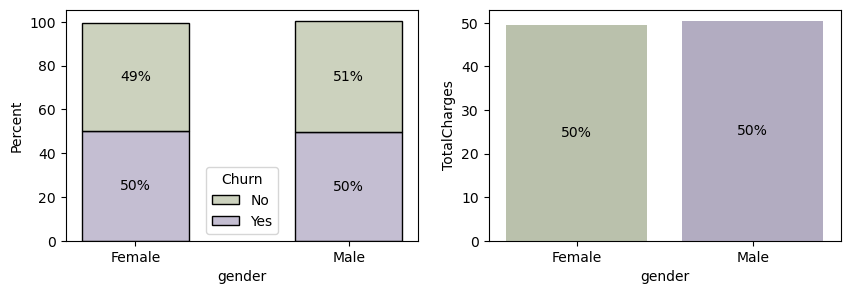

Churn distribution by InternetService


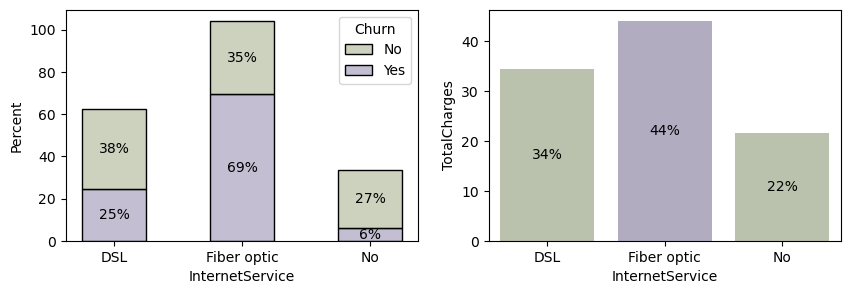

Churn distribution by StreamingTV


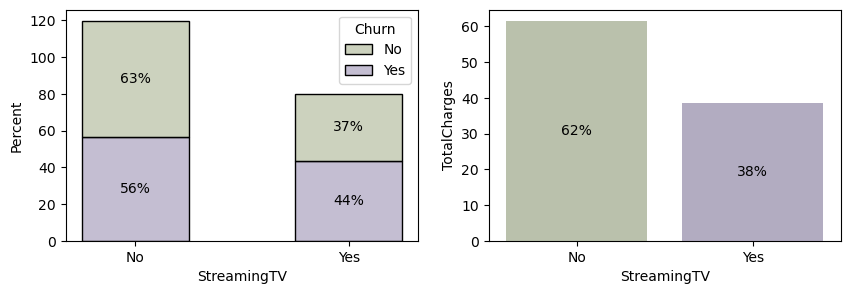

Churn distribution by StreamingMovies


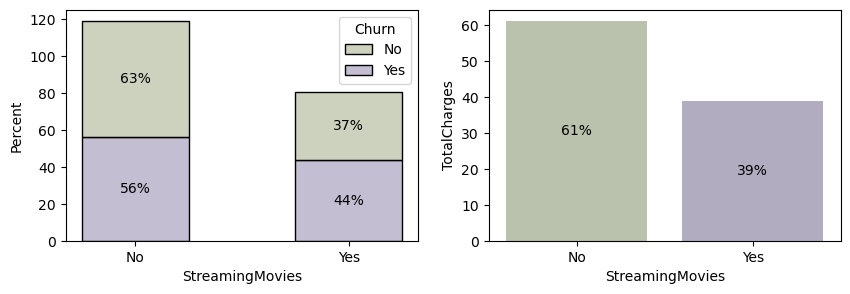

In [116]:
plot_expl(df,['gender','InternetService','StreamingTV','StreamingMovies'])

Churn distribution by TotalCharges


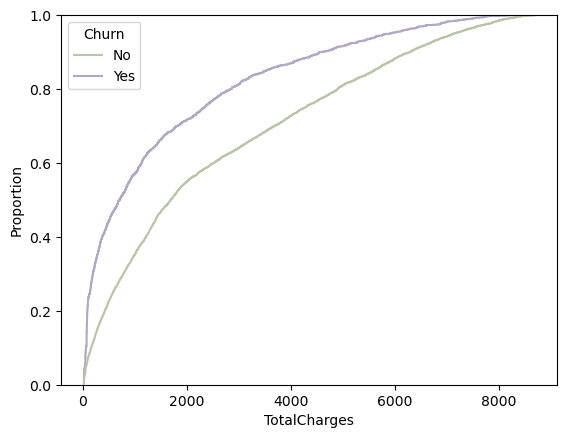

In [117]:
cdf_plot(df,['TotalCharges'])

Churn distribution by MonthlyCharges


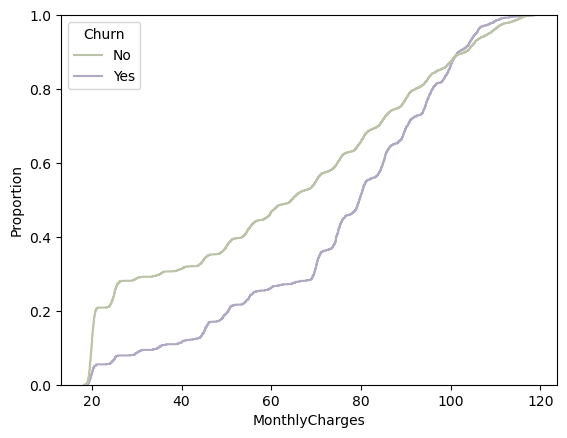

In [118]:
cdf_plot(df,['MonthlyCharges'])

In [119]:
df['Churn'] = df['Churn'].replace({'No':0,'Yes':1})

### Further Processing

In [120]:
labels = df['Churn']
features = df.drop('Churn',axis=1)


In [121]:
features = pd.get_dummies(features,drop_first=True,dtype='int64')
features.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,1,1,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [122]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.2, random_state=42, stratify=labels)

In [123]:
# Scaling
cols_to_be_scaled = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
X_train[cols_to_be_scaled] = scaler.fit_transform(X_train[cols_to_be_scaled])

### Decision Tree Classifier

In [148]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced')

In [149]:
X_test[cols_to_be_scaled] = scaler.transform(X_test[cols_to_be_scaled])


In [150]:
y_hat = model.predict(X_test)

In [151]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1033
           1       0.50      0.70      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407



In [152]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [154]:
params_list_dt = {
    'criterion':['gini','entropy'],
    'min_samples_split':np.arange(15,30),
}

In [155]:
randomSearch = RandomizedSearchCV(model,params_list_dt,cv=3)

In [156]:
randomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced'),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [157]:
randomSearch.best_params_

{'min_samples_split': 26, 'criterion': 'entropy'}

In [158]:
best_dr_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=26)
best_dr_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=26)

In [159]:
y_hat_dt = best_dr_model.predict(X_test)

In [160]:
print(classification_report(y_test,y_hat_dt))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1033
           1       0.50      0.72      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407



### Logistic Regression

In [129]:
#LR1 
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train,y_train)


LogisticRegression(class_weight='balanced')

In [130]:
y_hat_1 = model1.predict(X_test)

In [131]:
print(classification_report(y_test,y_hat_1))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [132]:
params_list_lr = {'C': uniform(0.001, 10),  # uniform rand sample
    'penalty': ['l1', 'l2'],
    'max_iter': np.arange(100, 1000, 100)}

In [133]:
randomSearch = RandomizedSearchCV(model1,params_list_lr,cv=3)

In [134]:
randomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B8DB2EF100>,
                                        'max_iter': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'penalty': ['l1', 'l2']})

In [141]:
randomSearch.best_params_

{'C': 3.625652032981218, 'max_iter': 100, 'penalty': 'l2'}

In [142]:
best_lr_model = LogisticRegression(C=3.8913213712095316,max_iter=900,penalty='l2',class_weight='balanced')
best_lr_model.fit(X_train,y_train)

LogisticRegression(C=3.8913213712095316, class_weight='balanced', max_iter=900)

In [143]:
y_hat_1 = best_lr_model.predict(X_test)

In [144]:
print(classification_report(y_test,y_hat_1))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [145]:
X = features
y = labels

X[cols_to_be_scaled] = scaler.transform(X[cols_to_be_scaled])

In [146]:
recalls_list = cross_val_score(best_lr_model,X,y,scoring='recall',cv=5)

In [194]:
for i in recalls_list:
    print(i," ")

0.8368983957219251  
0.8235294117647058  
0.8123324396782842  
0.7807486631016043  
0.7647058823529411  


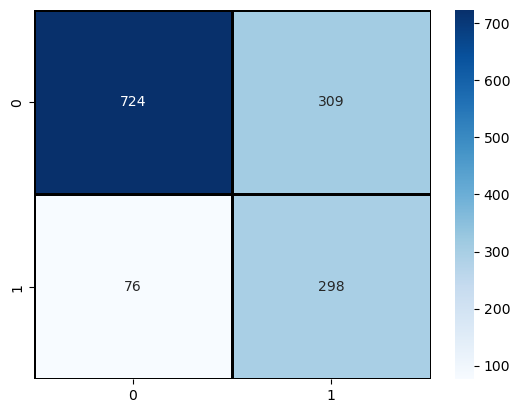

In [195]:
cm_log_reg = confusion_matrix(y_test,y_hat_1)
sns.heatmap(cm_log_reg,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['0','1'] , yticklabels = ['0','1'])
plt.show()

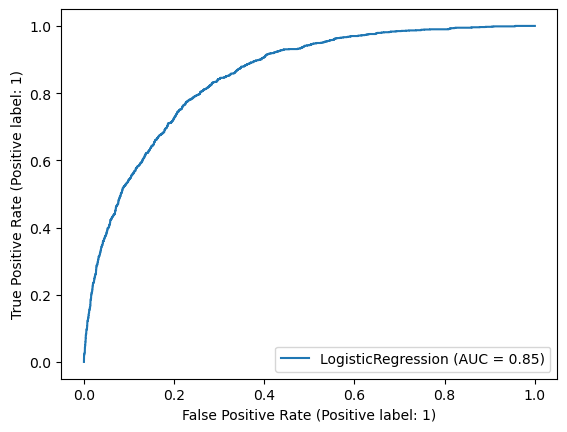

In [199]:
RocCurveDisplay.from_estimator(best_lr_model,X_test,y_test)
plt.show()

### Random Forest Classifier

In [170]:
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train,y_train)

y_pred_rf = rf_clf.predict(X_test)

In [171]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.54      0.58      0.56       374

    accuracy                           0.76      1407
   macro avg       0.69      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



In [173]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [183]:
params_list_rf = {'n_estimators':np.arange(50,200,10),
    'criterion':['gini','entropy'],
    'min_samples_split':np.arange(15,30),
}

In [184]:
randomSearch = RandomizedSearchCV(rf_clf,params_list_rf,cv=5)

In [185]:
randomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190])})

In [186]:
randomSearch.best_params_

{'n_estimators': 170, 'min_samples_split': 19, 'criterion': 'gini'}

In [187]:
best_rf = RandomForestClassifier(n_estimators=170,min_samples_split=19,criterion='gini')
best_rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=19, n_estimators=170)

In [188]:
y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1033
           1       0.50      0.68      0.57       374

    accuracy                           0.73      1407
   macro avg       0.68      0.71      0.69      1407
weighted avg       0.77      0.73      0.74      1407



In [167]:
print("The cross validation recall rate: %.2f%%" % (np.mean(recalls_list)*100))

The cross validation recall rate: 80.36%
